In [5]:
#Import required Python Libraries

import pandas as pd
import numpy as np
import math
from scipy import stats
import statsmodels.stats.power as smp

In [6]:
#Import all input csv data files

assigned_users_df_temp = pd.read_csv("assigned_users.csv")
eligible_users_df = pd.read_csv("eligible_users.csv")
launching_users_df = pd.read_csv("launching_users.csv")
purchasing_users_df = pd.read_csv("purchasing_users.csv")

# New Section

In [7]:
#Check data types

assigned_users_df_temp.info()
eligible_users_df.info()
launching_users_df.info()
purchasing_users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191641 entries, 0 to 1191640
Data columns (total 5 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   anon_id                     1191641 non-null  object
 1   variant                     1191641 non-null  object
 2   spammer_participant         1191641 non-null  bool  
 3   crossover_participant       1191641 non-null  bool  
 4   attribution_start_datetime  1191641 non-null  object
dtypes: bool(2), object(3)
memory usage: 29.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601952 entries, 0 to 601951
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   anon_id         601952 non-null  object
 1   eventtimestamp  601952 non-null  int64 
 2   event_order     601952 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [8]:
#Check datasets for missing values

assigned_users_null_counts = assigned_users_df_temp.isnull().sum()
eligible_users_null_counts = eligible_users_df.isnull().sum()
launching_users_null_counts = launching_users_df.isnull().sum()
purchasing_users_null_counts = purchasing_users_df.isnull().sum()

print("\n assigned_users \n",assigned_users_null_counts)
print("\n eligible_users \n",eligible_users_null_counts)
print("\n launching_users \n",launching_users_null_counts)
print("\n purchasing_users \n",purchasing_users_null_counts)

#There are no missing values in any of the columns


 assigned_users 
 anon_id                       0
variant                       0
spammer_participant           0
crossover_participant         0
attribution_start_datetime    0
dtype: int64

 eligible_users 
 anon_id           0
eventtimestamp    0
event_order       0
dtype: int64

 launching_users 
 anon_id           0
eventtimestamp    0
event_order       0
dtype: int64

 purchasing_users 
 anon_id        0
plan_type      0
wp_sales_7d    0
dtype: int64


In [9]:
#Check head of each dataset to understand columns
#Assigned users

assigned_users_df_temp.head()


,anon_id,variant,spammer_participant,crossover_participant,attribution_start_datetime
0,93223d4929f6bc4a42c18a6833fba71d191515ca690816...,control,False,False,2025-02-16 17:04:25.343
1,70626d7b0e6834aa93d70e77f1ab4f1eefb221d663975c...,treatment,False,False,2025-02-19 17:02:28.016
2,685f32edca52caed3fb666289b5030d156f20a439006f0...,treatment,False,False,2025-02-09 16:26:50.456
3,cd21936cf22d83a7f1f8b1447df9c8f822373efcabfe6c...,control,False,False,2025-02-19 08:17:36.621
4,1ac550d731d3bd79ea650439e38578df05f9e2e73610ee...,treatment,False,False,2025-02-17 14:15:35.742


In [10]:
#excluding crossover participants
assigned_users_df = assigned_users_df_temp[assigned_users_df_temp['crossover_participant'] == False]

In [11]:
assigned_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1177025 entries, 0 to 1191640
Data columns (total 5 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   anon_id                     1177025 non-null  object
 1   variant                     1177025 non-null  object
 2   spammer_participant         1177025 non-null  bool  
 3   crossover_participant       1177025 non-null  bool  
 4   attribution_start_datetime  1177025 non-null  object
dtypes: bool(2), object(3)
memory usage: 38.2+ MB


In [12]:
#Create a new column converting attribution_start_datetime to Date to analyze test/control split by date

assigned_users_df['attribution_start_date'] = assigned_users_df['attribution_start_datetime'].str[:10]

assigned_users_df.head()

<ipython-input-12-fdefb0b12417>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_users_df['attribution_start_date'] = assigned_users_df['attribution_start_datetime'].str[:10]


,anon_id,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date
0,93223d4929f6bc4a42c18a6833fba71d191515ca690816...,control,False,False,2025-02-16 17:04:25.343,2025-02-16
1,70626d7b0e6834aa93d70e77f1ab4f1eefb221d663975c...,treatment,False,False,2025-02-19 17:02:28.016,2025-02-19
2,685f32edca52caed3fb666289b5030d156f20a439006f0...,treatment,False,False,2025-02-09 16:26:50.456,2025-02-09
3,cd21936cf22d83a7f1f8b1447df9c8f822373efcabfe6c...,control,False,False,2025-02-19 08:17:36.621,2025-02-19
4,1ac550d731d3bd79ea650439e38578df05f9e2e73610ee...,treatment,False,False,2025-02-17 14:15:35.742,2025-02-17


In [13]:
assigned_users_df['start_datetime'] = pd.to_datetime(assigned_users_df['attribution_start_datetime'])

<ipython-input-13-9da2efc39d2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_users_df['start_datetime'] = pd.to_datetime(assigned_users_df['attribution_start_datetime'])


In [14]:
#Check that anon_id is unique in the assigned_users dataset

print(assigned_users_df['anon_id'].nunique())

print(assigned_users_df['anon_id'].count())

assigned_users_df['anon_id'].is_unique

1177025
1177025


True

In [15]:
#Writing a function to automate the distribution analysis across multiple datasets

def distribution_analysis(df, select_columns):
    results = {}
    for col in select_columns:
        value_counts = df[col].value_counts(dropna=False)
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100
        results[col] = pd.DataFrame({
            'Distribution Count': value_counts,
            'Distribution Pct': percentages
        })
    return results

In [16]:
#High level distribution check of all the columns

#Assigned users

assigned_users_select_columns = ['variant', 'spammer_participant', 'crossover_participant']
results = distribution_analysis(assigned_users_df, assigned_users_select_columns)

for col, result_df in results.items():
    print(f"\n Column: {col}")
    print(result_df)



 Column: variant
           Distribution Count  Distribution Pct
variant                                        
treatment              590367         50.157558
control                586658         49.842442

 Column: spammer_participant
                     Distribution Count  Distribution Pct
spammer_participant                                      
False                           1067063         90.657633
True                             109962          9.342367

 Column: crossover_participant
                       Distribution Count  Distribution Pct
crossover_participant                                      
False                             1177025             100.0


In [17]:
#Analyze distribution of control and treatment assigned user counts by date to check even split

users_date_xtab = pd.crosstab(assigned_users_df['attribution_start_date'], assigned_users_df['variant'])

users_date_xtab.head()

variant,control,treatment
attribution_start_date,,
2025-02-04,38334,38231
2025-02-05,36610,37034
2025-02-06,36706,37219
2025-02-07,33615,33819
2025-02-08,29965,30492


In [18]:
#Calculate percentage of user counts assigned to control and treatment by date to check for Sample Ratio Mismatch


users_date_xtab['control_pct'] = users_date_xtab['control'] / (users_date_xtab['control'] + users_date_xtab['treatment'])
users_date_xtab['treatment_pct'] = users_date_xtab['treatment'] / (users_date_xtab['control'] + users_date_xtab['treatment'])

users_date_xtab

#From a visual read of the Cross-tab below, looks like there is no Sample Ratio Mismatch between Treatment/Control

variant,control,treatment,control_pct,treatment_pct
attribution_start_date,,,,
2025-02-04,38334,38231,0.500673,0.499327
2025-02-05,36610,37034,0.497121,0.502879
2025-02-06,36706,37219,0.496530,0.503470
2025-02-07,33615,33819,0.498487,0.501513
2025-02-08,29965,30492,0.495642,0.504358
2025-02-09,29660,29636,0.500202,0.499798
2025-02-10,37130,37555,0.497155,0.502845
2025-02-11,37516,37686,0.498870,0.501130
2025-02-12,37080,36287,0.505404,0.494596


Plotting the daily percentages to visually inspect for mismatches:

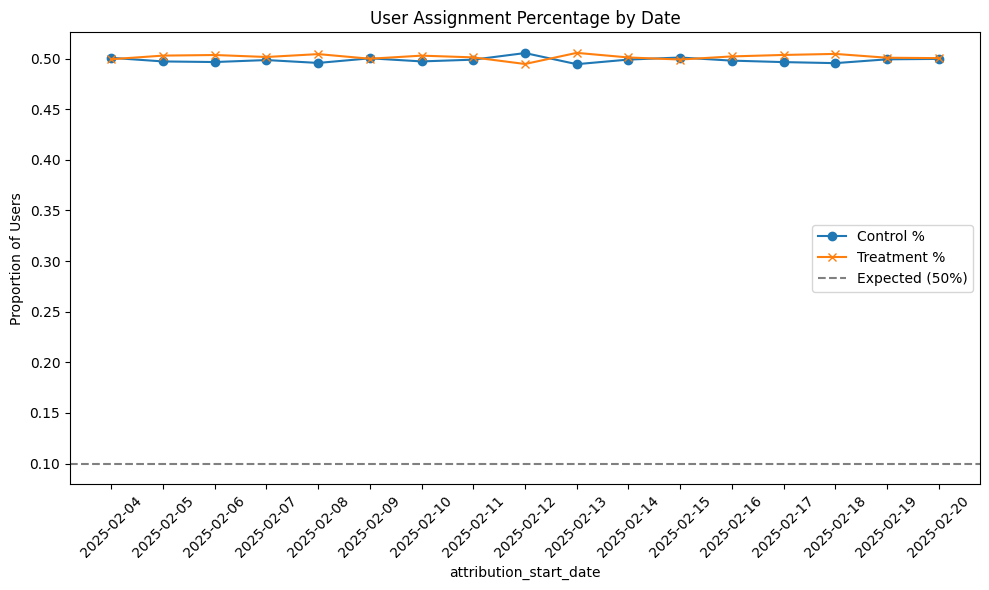

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(users_date_xtab.index, users_date_xtab['control_pct'], label='Control %', marker='o')
plt.plot(users_date_xtab.index, users_date_xtab['treatment_pct'], label='Treatment %', marker='x')
plt.axhline(0.1, color='gray', linestyle='--', label='Expected (50%)')
plt.title('User Assignment Percentage by Date')
plt.ylabel('Proportion of Users')
plt.xlabel('attribution_start_date')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
#Analyze distribution of control and treatment assigned user counts by date to check even split

users_spam_xtab = pd.crosstab(assigned_users_df['spammer_participant'], assigned_users_df['variant'])

users_spam_xtab

variant,control,treatment
spammer_participant,,
False,515986,551077
True,70672,39290


In [21]:
#Calculate percentage of user counts assigned to control and treatment by date to check for Sample Ratio Mismatch

users_spam_xtab['control_pct'] = users_spam_xtab['control'] / (users_spam_xtab['control'] + users_spam_xtab['treatment'])
users_spam_xtab['treatment_pct'] = users_spam_xtab['treatment'] / (users_spam_xtab['control'] + users_spam_xtab['treatment'])

users_spam_xtab

variant,control,treatment,control_pct,treatment_pct
spammer_participant,,,,
False,515986,551077,0.483557,0.516443
True,70672,39290,0.642695,0.357305


1.  From a visual read of the Cross-tab above, there is a skew (64% of spam participants are in Control, only 36% in Treatment)
2.   There might have been a bug affecting the random assignment of Potential Spam participants between Control and Treatment
3.   The Question has asked us to include the Spam participants as the spam detection algorithm may not have worked properly
4.   So we are not excluding the Spammer Participants, but will observe the metrics closely to ensure there is no skewness

Variant Distribution:
variant
treatment    590367
control      586658
Name: count, dtype: int64


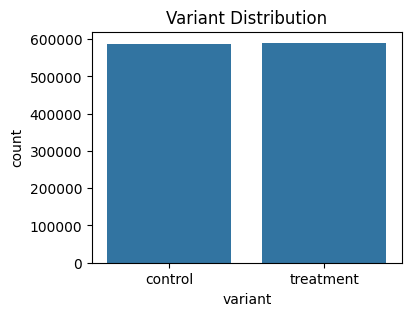


Spammer Participant Distribution:
spammer_participant
False    1067063
True      109962
Name: count, dtype: int64


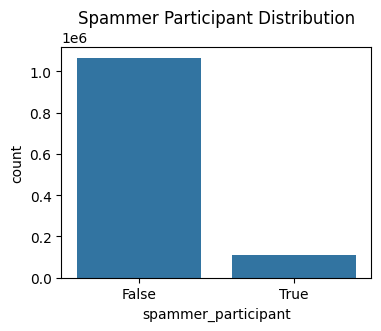

<ipython-input-22-0e890b004e94>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_users_df['attribution_start_date'] = pd.to_datetime(assigned_users_df['attribution_start_date'])


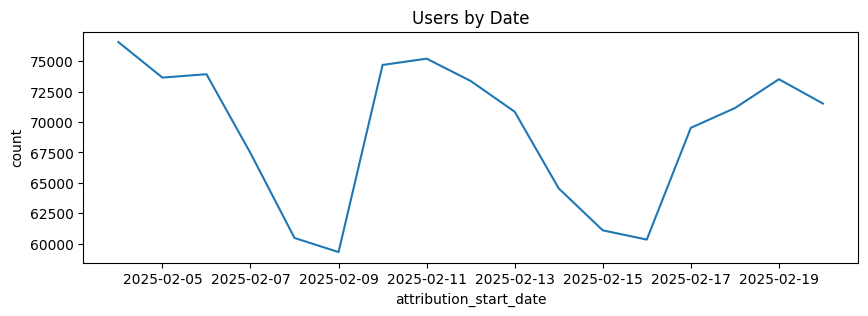


Sample Ratio Mismatch (SRM) Check:
variant                 control  treatment  control_pct  treatment_pct
attribution_start_date                                                
2025-02-04                38334      38231     0.500673       0.499327
2025-02-05                36610      37034     0.497121       0.502879
2025-02-06                36706      37219     0.496530       0.503470
2025-02-07                33615      33819     0.498487       0.501513
2025-02-08                29965      30492     0.495642       0.504358
2025-02-09                29660      29636     0.500202       0.499798
2025-02-10                37130      37555     0.497155       0.502845
2025-02-11                37516      37686     0.498870       0.501130
2025-02-12                37080      36287     0.505404       0.494596
2025-02-13                35023      35814     0.494417       0.505583
2025-02-14                32199      32334     0.498954       0.501046
2025-02-15                30603      3048

In [22]:
# EDA on assigned users dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def eda_assigned_users(assigned_users_df):
    # Distribution of variant
    variant_counts = assigned_users_df['variant'].value_counts()
    print("Variant Distribution:")
    print(variant_counts)
    plt.figure(figsize=(4, 3))
    sns.countplot(data=assigned_users_df, x='variant')
    plt.title("Variant Distribution")
    plt.show()

    # Distribution of spammer participants
    spammer_counts = assigned_users_df['spammer_participant'].value_counts()
    print("\nSpammer Participant Distribution:")
    print(spammer_counts)
    plt.figure(figsize=(4, 3))
    sns.countplot(data=assigned_users_df, x='spammer_participant')
    plt.title("Spammer Participant Distribution")
    plt.show()



    # Distribution of users by date
    assigned_users_df['attribution_start_date'] = pd.to_datetime(assigned_users_df['attribution_start_date'])
    users_by_date = assigned_users_df.groupby('attribution_start_date').size().reset_index(name='count')
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=users_by_date, x='attribution_start_date', y='count')
    plt.title("Users by Date")
    plt.show()

    # Sample Ratio Mismatch (SRM) check
    users_date_xtab = pd.crosstab(assigned_users_df['attribution_start_date'], assigned_users_df['variant'])
    users_date_xtab['control_pct'] = users_date_xtab['control'] / (users_date_xtab['control'] + users_date_xtab['treatment'])
    users_date_xtab['treatment_pct'] = users_date_xtab['treatment'] / (users_date_xtab['control'] + users_date_xtab['treatment'])
    print("\nSample Ratio Mismatch (SRM) Check:")
    print(users_date_xtab)

    # Spammer participant distribution by variant
    spammer_variant_xtab = pd.crosstab(assigned_users_df['spammer_participant'], assigned_users_df['variant'])
    spammer_variant_xtab['control_pct'] = spammer_variant_xtab['control'] / (spammer_variant_xtab['control'] + spammer_variant_xtab['treatment'])
    spammer_variant_xtab['treatment_pct'] = spammer_variant_xtab['treatment'] / (spammer_variant_xtab['control'] + spammer_variant_xtab['treatment'])
    print("\nSpammer Participant Distribution by Variant:")
    print(spammer_variant_xtab)

# Call the EDA function
eda_assigned_users(assigned_users_df)

In [23]:
#Check head of each dataset to understand columns
#Eligible users

eligible_users_df.head()


,anon_id,eventtimestamp,event_order
0,2ede5d248586ebd024fa4ed67048362c04d5c075efb4d5...,1738800597595,1
1,a0a244d0208268d7ae8c63aea0fae6403d230815bca56f...,1739775344049,1
2,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739439930048,1
3,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739440138503,2
4,9549d54385c2e93ce7286624f7128dda158f69e7f6f9a1...,1739567135806,1


In [24]:
#Convert column 'eventtimestamp' from epoch to timestamp format

eligible_users_df['eventtimestamp_time'] = pd.to_datetime(eligible_users_df['eventtimestamp'], unit='ms')

eligible_users_df['eventtimestamp_date'] = eligible_users_df['eventtimestamp_time'].dt.date

eligible_users_df.head()


,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date
0,2ede5d248586ebd024fa4ed67048362c04d5c075efb4d5...,1738800597595,1,2025-02-06 00:09:57.595,2025-02-06
1,a0a244d0208268d7ae8c63aea0fae6403d230815bca56f...,1739775344049,1,2025-02-17 06:55:44.049,2025-02-17
2,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739439930048,1,2025-02-13 09:45:30.048,2025-02-13
3,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739440138503,2,2025-02-13 09:48:58.503,2025-02-13
4,9549d54385c2e93ce7286624f7128dda158f69e7f6f9a1...,1739567135806,1,2025-02-14 21:05:35.806,2025-02-14


In [25]:
#Join ELigible users table and Assigned users table on anon_id

eligible_assigned_users = pd.merge(eligible_users_df, assigned_users_df, left_on='anon_id', right_on='anon_id', how='left')

eligible_assigned_users

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime
0,2ede5d248586ebd024fa4ed67048362c04d5c075efb4d5...,1738800597595,1,2025-02-06 00:09:57.595,2025-02-06,treatment,False,False,2025-02-06 00:09:34.669,2025-02-06,2025-02-06 00:09:34.669
1,a0a244d0208268d7ae8c63aea0fae6403d230815bca56f...,1739775344049,1,2025-02-17 06:55:44.049,2025-02-17,treatment,False,False,2025-02-17 06:55:40.426,2025-02-17,2025-02-17 06:55:40.426
2,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739439930048,1,2025-02-13 09:45:30.048,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885
3,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739440138503,2,2025-02-13 09:48:58.503,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885
4,9549d54385c2e93ce7286624f7128dda158f69e7f6f9a1...,1739567135806,1,2025-02-14 21:05:35.806,2025-02-14,treatment,False,False,2025-02-14 21:05:27.929,2025-02-14,2025-02-14 21:05:27.929
...,...,...,...,...,...,...,...,...,...,...,...
601947,af7c3a00cb2d51bfa8030e38f7b3981b81ce1e7f7eb1de...,1740065127860,3,2025-02-20 15:25:27.860,2025-02-20,control,False,False,2025-02-20 15:25:04.542,2025-02-20,2025-02-20 15:25:04.542
601948,459798a1c94b43bfafc0b348a62c4c877b13ea498a887c...,1739982844987,1,2025-02-19 16:34:04.987,2025-02-19,treatment,False,False,2025-02-19 16:34:04.285,2025-02-19,2025-02-19 16:34:04.285
601949,86a00439899677544ba0568ab79bf2f4d02d8a8407fbe2...,1738745234587,1,2025-02-05 08:47:14.587,2025-02-05,control,False,False,2025-02-05 08:47:09.701,2025-02-05,2025-02-05 08:47:09.701
601950,1be18b68adb0d2718672c6992a38ebaa0a28324bfa988e...,1739769503556,1,2025-02-17 05:18:23.556,2025-02-17,treatment,False,False,2025-02-17 05:17:39.096,2025-02-17,2025-02-17 05:17:39.096


In [26]:
eligible_assigned_users['Date_Diff'] = eligible_assigned_users['eventtimestamp_time'] - eligible_assigned_users['start_datetime']

In [27]:
eligible_assigned_users['time_difference_seconds'] = eligible_assigned_users['Date_Diff'].dt.total_seconds()

In [28]:
eligible_assigned_users.head(5)

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds
0,2ede5d248586ebd024fa4ed67048362c04d5c075efb4d5...,1738800597595,1,2025-02-06 00:09:57.595,2025-02-06,treatment,False,False,2025-02-06 00:09:34.669,2025-02-06,2025-02-06 00:09:34.669,0 days 00:00:22.926000,22.926
1,a0a244d0208268d7ae8c63aea0fae6403d230815bca56f...,1739775344049,1,2025-02-17 06:55:44.049,2025-02-17,treatment,False,False,2025-02-17 06:55:40.426,2025-02-17,2025-02-17 06:55:40.426,0 days 00:00:03.623000,3.623
2,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739439930048,1,2025-02-13 09:45:30.048,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885,0 days 00:00:03.163000,3.163
3,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739440138503,2,2025-02-13 09:48:58.503,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885,0 days 00:03:31.618000,211.618
4,9549d54385c2e93ce7286624f7128dda158f69e7f6f9a1...,1739567135806,1,2025-02-14 21:05:35.806,2025-02-14,treatment,False,False,2025-02-14 21:05:27.929,2025-02-14,2025-02-14 21:05:27.929,0 days 00:00:07.877000,7.877


 Removing rows where sessions/exposures happened before the user was assigned to the test, conversion to timestamp, etc

In [29]:
#keeping rows where eventtimestamp_time is greater than the attribution start time
eligible_assigned_users_final = eligible_assigned_users[eligible_assigned_users['time_difference_seconds'] > 0]

In [30]:
eligible_assigned_users_final.head(10)

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds
0,2ede5d248586ebd024fa4ed67048362c04d5c075efb4d5...,1738800597595,1,2025-02-06 00:09:57.595,2025-02-06,treatment,False,False,2025-02-06 00:09:34.669,2025-02-06,2025-02-06 00:09:34.669,0 days 00:00:22.926000,22.926
1,a0a244d0208268d7ae8c63aea0fae6403d230815bca56f...,1739775344049,1,2025-02-17 06:55:44.049,2025-02-17,treatment,False,False,2025-02-17 06:55:40.426,2025-02-17,2025-02-17 06:55:40.426,0 days 00:00:03.623000,3.623
2,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739439930048,1,2025-02-13 09:45:30.048,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885,0 days 00:00:03.163000,3.163
3,4cf858e23a77f318ae26d29d05c2b7d3202c63cd85f643...,1739440138503,2,2025-02-13 09:48:58.503,2025-02-13,control,False,False,2025-02-13 09:45:26.885,2025-02-13,2025-02-13 09:45:26.885,0 days 00:03:31.618000,211.618
4,9549d54385c2e93ce7286624f7128dda158f69e7f6f9a1...,1739567135806,1,2025-02-14 21:05:35.806,2025-02-14,treatment,False,False,2025-02-14 21:05:27.929,2025-02-14,2025-02-14 21:05:27.929,0 days 00:00:07.877000,7.877
5,307df4a25b38fe620c246dfc042d488617ea13b5bcbfde...,1739174173961,1,2025-02-10 07:56:13.961,2025-02-10,control,True,False,2025-02-10 07:55:57.077,2025-02-10,2025-02-10 07:55:57.077,0 days 00:00:16.884000,16.884
6,c25f654146aafe40eee029c70a1d4b48579417e2209c9c...,1739025368474,1,2025-02-08 14:36:08.474,2025-02-08,control,False,False,2025-02-08 14:36:03.557,2025-02-08,2025-02-08 14:36:03.557,0 days 00:00:04.917000,4.917
8,4b9660b1c910c445bfaf1ff279a77a864cb745a13e6658...,1739376679982,1,2025-02-12 16:11:19.982,2025-02-12,treatment,False,False,2025-02-12 16:11:10.312,2025-02-12,2025-02-12 16:11:10.312,0 days 00:00:09.670000,9.670
9,c61b6edc0ee5448a68ab43840caa51df61808b5569ebed...,1739945568337,1,2025-02-19 06:12:48.337,2025-02-19,control,False,False,2025-02-19 06:12:44.035,2025-02-19,2025-02-19 06:12:44.035,0 days 00:00:04.302000,4.302
10,f84bd1901dc90fd633cf5cbc36e64e32de26be2e1738d2...,1739990328327,1,2025-02-19 18:38:48.327,2025-02-19,treatment,False,False,2025-02-19 18:38:30.968,2025-02-19,2025-02-19 18:38:30.968,0 days 00:00:17.359000,17.359


Summary Statistics of Time Difference in Seconds:
count    5.587160e+05
mean     4.602311e+04
std      1.419596e+07
min      1.000000e-03
25%      9.018000e+00
50%      1.736900e+01
75%      5.363225e+01
max      6.939256e+09
Name: time_difference_seconds, dtype: float64

Variant Distribution:
variant
treatment    282234
control      276482
Name: count, dtype: int64


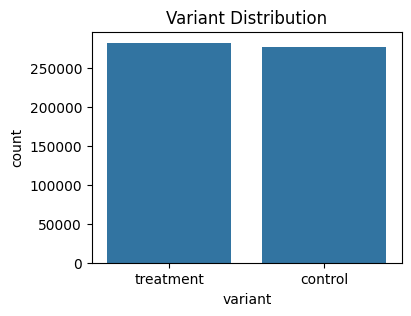


Spammer Participant Distribution:
spammer_participant
False    454756
True     103960
Name: count, dtype: int64


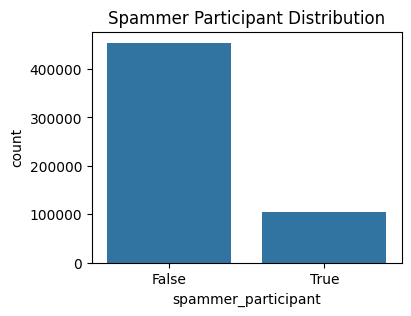


Correlation between Time Difference and Other Columns:
time_difference_seconds    1.0
event_order                NaN
eventtimestamp             NaN
dtype: float64


In [89]:
# EDA on eligible_assigned_users_final dataset
def eda_eligible_assigned_users(eligible_assigned_users_final):


    # Summary statistics of time difference in seconds
    print("Summary Statistics of Time Difference in Seconds:")
    print(eligible_assigned_users_final['time_difference_seconds'].describe())

    # Distribution of variant
    variant_counts = eligible_assigned_users_final['variant'].value_counts()
    print("\nVariant Distribution:")
    print(variant_counts)
    plt.figure(figsize=(4, 3))
    sns.countplot(data=eligible_assigned_users_final, x='variant')
    plt.title("Variant Distribution")
    plt.show()

    # Distribution of spammer participants
    spammer_counts = eligible_assigned_users_final['spammer_participant'].value_counts()
    print("\nSpammer Participant Distribution:")
    print(spammer_counts)
    plt.figure(figsize=(4, 3))
    sns.countplot(data=eligible_assigned_users_final, x='spammer_participant')
    plt.title("Spammer Participant Distribution")
    plt.show()

    # Correlation between time difference and other columns
    corr_matrix = eligible_assigned_users_final[['time_difference_seconds']].corrwith(eligible_assigned_users_final.select_dtypes(include=['int64', 'float64']))
    print("\nCorrelation between Time Difference and Other Columns:")
    print(corr_matrix)



# Call the EDA function
eda_eligible_assigned_users(eligible_assigned_users_final)

In [32]:
#Check head of each dataset to understand columns
#Eligible users

launching_users_df.head()


,anon_id,eventtimestamp,event_order
0,d5a68b69042f6002e4453c683c9f74c751c36b1a196d91...,1738789748068,1
1,dba1f3aa182b255eedf542680629bb4ded6d1851000d42...,1739990708783,1
2,f03cd6c4b871caea27a73cef337d15ce8fdcc6dfcbef26...,1740375966333,1
3,3a977f52b3ede2b53d739e720c514e05a907020b02d720...,1738748896448,1
4,5efa641288b8f32f7a5235290a0c0a6547950729a3a9f1...,1739309794718,1


In [33]:
#Convert column 'eventtimestamp' from epoch to timestamp format

launching_users_df['eventtimestamp_time'] = pd.to_datetime(launching_users_df['eventtimestamp'], unit='ms')

launching_users_df['eventtimestamp_date'] = launching_users_df['eventtimestamp_time'].dt.date

launching_users_df = launching_users_df.rename(columns={'eventtimestamp': 'launch_eventtimestamp'})
launching_users_df = launching_users_df.rename(columns={'event_order': 'launch_event_order'})
launching_users_df = launching_users_df.rename(columns={'eventtimestamp_time': 'launch_eventtimestamp_time'})
launching_users_df = launching_users_df.rename(columns={'eventtimestamp_date': 'launch_eventtimestamp_date'})

launching_users_df.head()


,anon_id,launch_eventtimestamp,launch_event_order,launch_eventtimestamp_time,launch_eventtimestamp_date
0,d5a68b69042f6002e4453c683c9f74c751c36b1a196d91...,1738789748068,1,2025-02-05 21:09:08.068,2025-02-05
1,dba1f3aa182b255eedf542680629bb4ded6d1851000d42...,1739990708783,1,2025-02-19 18:45:08.783,2025-02-19
2,f03cd6c4b871caea27a73cef337d15ce8fdcc6dfcbef26...,1740375966333,1,2025-02-24 05:46:06.333,2025-02-24
3,3a977f52b3ede2b53d739e720c514e05a907020b02d720...,1738748896448,1,2025-02-05 09:48:16.448,2025-02-05
4,5efa641288b8f32f7a5235290a0c0a6547950729a3a9f1...,1739309794718,1,2025-02-11 21:36:34.718,2025-02-11


For analyzing site launch rate, I aggregated all the data at the session/event level

In [34]:
eligible_assigned_users_final = eligible_assigned_users_final.sort_values(['anon_id', 'eventtimestamp_time']).reset_index(drop=True)
launching_users_df = launching_users_df.sort_values(['anon_id', 'launch_eventtimestamp_time']).reset_index(drop=True)

eligible_assigned_users_final = eligible_assigned_users_final.sort_values(['eventtimestamp_time'])
launching_users_df = launching_users_df.sort_values(['launch_eventtimestamp_time'])


#Join ELigible Assigned users table with Launching users table on anon_id

master_launch_table_df = pd.merge_asof(
    eligible_assigned_users_final,
    launching_users_df,
    left_on='eventtimestamp_time',
    right_on='launch_eventtimestamp_time',
    by='anon_id',
    direction='forward'
)

master_launch_table_df

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds,launch_eventtimestamp,launch_event_order,launch_eventtimestamp_time,launch_eventtimestamp_date
0,260da15fefea36c7bcda23e832dae351864d24de2dcf56...,1738627218104,1,2025-02-04 00:00:18.104,2025-02-04,treatment,False,False,2025-02-04 00:00:05.480,2025-02-04,2025-02-04 00:00:05.480,0 days 00:00:12.624000,1.262400e+01,NaN,NaN,NaT,NaN
1,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627218633,1,2025-02-04 00:00:18.633,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:07.673000,7.673000e+00,NaN,NaN,NaT,NaN
2,25cd3f0fa6c0ee6cc77ca588b8ebf2879649b9bafea01b...,1738627241695,1,2025-02-04 00:00:41.695,2025-02-04,control,False,False,2025-02-04 00:00:00.432,2025-02-04,2025-02-04 00:00:00.432,0 days 00:00:41.263000,4.126300e+01,NaN,NaN,NaT,NaN
3,1027039ed70469c054ccd3a08886c1d95638d5981b3c86...,1738627242637,1,2025-02-04 00:00:42.637,2025-02-04,treatment,False,False,2025-02-04 00:00:30.667,2025-02-04,2025-02-04 00:00:30.667,0 days 00:00:11.970000,1.197000e+01,NaN,NaN,NaT,NaN
4,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627243097,2,2025-02-04 00:00:43.097,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:32.137000,3.213700e+01,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558711,6511687d6600e0971d8c1be4c385bf5594ab4c1438f581...,3218828970636,2,2071-12-31 23:09:30.636,2071-12-31,treatment,False,False,2025-02-18 06:32:51.344,2025-02-18,2025-02-18 06:32:51.344,17117 days 16:36:39.292000,1.478969e+09,NaN,NaN,NaT,NaN
558712,19028c9fe18e3e61f5158db8a07f17591b431d66d7d6d7...,6153651014786,1,2164-12-31 19:30:14.786,2164-12-31,control,False,False,2025-02-13 05:00:39.103,2025-02-13,2025-02-13 05:00:39.103,51090 days 14:29:35.683000,4.414228e+09,NaN,NaN,NaT,NaN
558713,32ab93e9b2b4da62d020eb24fcb10eb842ab24ca40df65...,6153651295489,1,2164-12-31 19:34:55.489,2164-12-31,treatment,False,False,2025-02-15 06:33:43.477,2025-02-15,2025-02-15 06:33:43.477,51088 days 13:01:12.012000,4.414050e+09,NaN,NaN,NaT,NaN
558714,5648f4d33a7369dbbe87a320f3499904ff7e35f9db00f0...,6153806417641,1,2165-01-02 14:40:17.641,2165-01-02,treatment,False,False,2025-02-19 03:34:27.632,2025-02-19,2025-02-19 03:34:27.632,51086 days 11:05:50.009000,4.413870e+09,NaN,NaN,NaT,NaN


In [35]:
#Check merge happened correctly

master_launch_table_df_launches_check = master_launch_table_df[master_launch_table_df['launch_event_order'].notna()]

master_launch_table_df_launches_check

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds,launch_eventtimestamp,launch_event_order,launch_eventtimestamp_time,launch_eventtimestamp_date
10,b9a5540c2e02d822415c30059d861009f331a3a126d1d7...,1738627255869,1,2025-02-04 00:00:55.869,2025-02-04,treatment,False,False,2025-02-04 00:00:41.348,2025-02-04,2025-02-04 00:00:41.348,0 days 00:00:14.521000,14.521,1.738628e+12,1.0,2025-02-04 00:05:09.860,2025-02-04
11,5fe9564dd3b6e8dfc001692f964f023315bacda977e2e0...,1738627264192,1,2025-02-04 00:01:04.192,2025-02-04,control,False,False,2025-02-04 00:00:51.480,2025-02-04,2025-02-04 00:00:51.480,0 days 00:00:12.712000,12.712,1.738628e+12,1.0,2025-02-04 00:07:50.226,2025-02-04
26,6fd90e8846c185da5cbbcb703cd4318acfd6ddcfb99bf1...,1738627315449,1,2025-02-04 00:01:55.449,2025-02-04,control,False,False,2025-02-04 00:01:50.224,2025-02-04,2025-02-04 00:01:50.224,0 days 00:00:05.225000,5.225,1.738629e+12,1.0,2025-02-04 00:22:17.523,2025-02-04
33,48fdfe85aef2b173dbf677fb8869f6d60cd3331177eb18...,1738627352578,1,2025-02-04 00:02:32.578,2025-02-04,treatment,False,False,2025-02-04 00:02:25.225,2025-02-04,2025-02-04 00:02:25.225,0 days 00:00:07.353000,7.353,1.738629e+12,1.0,2025-02-04 00:26:34.921,2025-02-04
69,58bb8f517d75e7c15c613ff41e3987b9c37e5b43ca4f87...,1738627525252,1,2025-02-04 00:05:25.252,2025-02-04,control,False,False,2025-02-04 00:05:00.480,2025-02-04,2025-02-04 00:05:00.480,0 days 00:00:24.772000,24.772,1.738631e+12,1.0,2025-02-04 01:00:01.871,2025-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558696,c66f01327dd43dcbbb7031e570673b4e6e5f38f53ad4fc...,1740179531176,5,2025-02-21 23:12:11.176,2025-02-21,control,False,False,2025-02-20 23:33:02.545,2025-02-20,2025-02-20 23:33:02.545,0 days 23:39:08.631000,85148.631,1.740408e+12,1.0,2025-02-24 14:45:43.266,2025-02-24
558697,cbbf5dde8aacd16f5d04a256f0dc72b075be048f8ff308...,1740179619438,5,2025-02-21 23:13:39.438,2025-02-21,control,False,False,2025-02-20 23:47:07.583,2025-02-20,2025-02-20 23:47:07.583,0 days 23:26:31.855000,84391.855,1.740180e+12,1.0,2025-02-21 23:23:20.557,2025-02-21
558698,cbbf5dde8aacd16f5d04a256f0dc72b075be048f8ff308...,1740180329721,6,2025-02-21 23:25:29.721,2025-02-21,control,False,False,2025-02-20 23:47:07.583,2025-02-20,2025-02-20 23:47:07.583,0 days 23:38:22.138000,85102.138,1.740207e+12,2.0,2025-02-22 06:47:59.404,2025-02-22
558699,cbbf5dde8aacd16f5d04a256f0dc72b075be048f8ff308...,1740180873526,7,2025-02-21 23:34:33.526,2025-02-21,control,False,False,2025-02-20 23:47:07.583,2025-02-20,2025-02-20 23:47:07.583,0 days 23:47:25.943000,85645.943,1.740207e+12,2.0,2025-02-22 06:47:59.404,2025-02-22


In [36]:
master_launch_table_df['launch_indicator'] = master_launch_table_df['launch_event_order'].apply(lambda x: 0 if pd.isna(x) else 1)

master_launch_table_df

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds,launch_eventtimestamp,launch_event_order,launch_eventtimestamp_time,launch_eventtimestamp_date,launch_indicator
0,260da15fefea36c7bcda23e832dae351864d24de2dcf56...,1738627218104,1,2025-02-04 00:00:18.104,2025-02-04,treatment,False,False,2025-02-04 00:00:05.480,2025-02-04,2025-02-04 00:00:05.480,0 days 00:00:12.624000,1.262400e+01,NaN,NaN,NaT,NaN,0
1,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627218633,1,2025-02-04 00:00:18.633,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:07.673000,7.673000e+00,NaN,NaN,NaT,NaN,0
2,25cd3f0fa6c0ee6cc77ca588b8ebf2879649b9bafea01b...,1738627241695,1,2025-02-04 00:00:41.695,2025-02-04,control,False,False,2025-02-04 00:00:00.432,2025-02-04,2025-02-04 00:00:00.432,0 days 00:00:41.263000,4.126300e+01,NaN,NaN,NaT,NaN,0
3,1027039ed70469c054ccd3a08886c1d95638d5981b3c86...,1738627242637,1,2025-02-04 00:00:42.637,2025-02-04,treatment,False,False,2025-02-04 00:00:30.667,2025-02-04,2025-02-04 00:00:30.667,0 days 00:00:11.970000,1.197000e+01,NaN,NaN,NaT,NaN,0
4,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627243097,2,2025-02-04 00:00:43.097,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:32.137000,3.213700e+01,NaN,NaN,NaT,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558711,6511687d6600e0971d8c1be4c385bf5594ab4c1438f581...,3218828970636,2,2071-12-31 23:09:30.636,2071-12-31,treatment,False,False,2025-02-18 06:32:51.344,2025-02-18,2025-02-18 06:32:51.344,17117 days 16:36:39.292000,1.478969e+09,NaN,NaN,NaT,NaN,0
558712,19028c9fe18e3e61f5158db8a07f17591b431d66d7d6d7...,6153651014786,1,2164-12-31 19:30:14.786,2164-12-31,control,False,False,2025-02-13 05:00:39.103,2025-02-13,2025-02-13 05:00:39.103,51090 days 14:29:35.683000,4.414228e+09,NaN,NaN,NaT,NaN,0
558713,32ab93e9b2b4da62d020eb24fcb10eb842ab24ca40df65...,6153651295489,1,2164-12-31 19:34:55.489,2164-12-31,treatment,False,False,2025-02-15 06:33:43.477,2025-02-15,2025-02-15 06:33:43.477,51088 days 13:01:12.012000,4.414050e+09,NaN,NaN,NaT,NaN,0
558714,5648f4d33a7369dbbe87a320f3499904ff7e35f9db00f0...,6153806417641,1,2165-01-02 14:40:17.641,2165-01-02,treatment,False,False,2025-02-19 03:34:27.632,2025-02-19,2025-02-19 03:34:27.632,51086 days 11:05:50.009000,4.413870e+09,NaN,NaN,NaT,NaN,0


In [37]:
print(master_launch_table_df['launch_indicator'].mean())

0.12982445464243014


In [38]:
master_launch_table_df.groupby('variant')['launch_indicator'].mean()

,launch_indicator
variant,
control,0.129491
treatment,0.130151


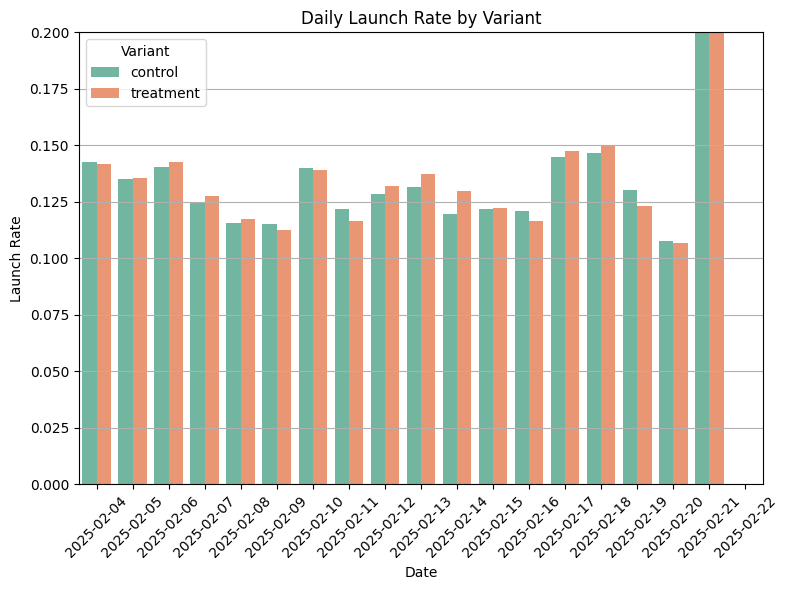

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract date part from timestamp
master_launch_table_df['event_date'] = master_launch_table_df['eventtimestamp_time'].dt.date

# Filter for dates up to and including Feb 22, 2025
filtered_df = master_launch_table_df[master_launch_table_df['event_date'] <= pd.to_datetime("2025-02-22").date()]

# Group by date and variant to compute mean launch rate
daily_launch_rates = filtered_df.groupby(['event_date', 'variant'])['launch_indicator'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=daily_launch_rates, x='event_date', y='launch_indicator', hue='variant', palette='Set2')

plt.title('Daily Launch Rate by Variant')
plt.xlabel('Date')
plt.ylabel('Launch Rate')
plt.xticks(rotation=45)
plt.ylim(0, 0.2)
plt.legend(title='Variant')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
launch_rate_power_test_df = master_launch_table_df.groupby('variant')['event_order'].count()

launch_rate_power_test_df = pd.DataFrame(launch_rate_power_test_df)

launch_rate_power_test_df = launch_rate_power_test_df.rename(columns={'event_order': 'event_count'})

launch_rate_power_test_df

,event_count
variant,
control,276482
treatment,282234


In [40]:
launch_rate_power_test_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, control to treatment
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   event_count  2 non-null      int64
dtypes: int64(1)
memory usage: 32.0+ bytes


In [41]:
test_sample_size = min(launch_rate_power_test_df['event_count'])

test_sample_size

276482

In [42]:
# EDA on master_launch_table_df dataset
def eda_master_launch_table(master_launch_table_df):

    # Summary statistics of time difference
    print("\nSummary Statistics of Time Difference:")
    print(master_launch_table_df['time_difference_seconds'].describe())

eda_master_launch_table(master_launch_table_df)


Summary Statistics of Time Difference:
count    5.587160e+05
mean     4.602311e+04
std      1.419596e+07
min      1.000000e-03
25%      9.018000e+00
50%      1.736900e+01
75%      5.363225e+01
max      6.939256e+09
Name: time_difference_seconds, dtype: float64


In [43]:
# Used LLm and Ai to generate the power test code to determine the required sample

def ab_test_power(baseline_conversion_rate, minimum_detectable_effect, alpha, beta):
    # Calculate the critical z-scores
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Two-tailed test
    z_beta = stats.norm.ppf(1 - beta)

    # Calculate the effect size
    effect_size = minimum_detectable_effect / math.sqrt(baseline_conversion_rate * (1 - baseline_conversion_rate))

    # Calculate the sample size
    sample_size = (z_alpha + z_beta) ** 2 * (baseline_conversion_rate * (1 - baseline_conversion_rate) + (baseline_conversion_rate + minimum_detectable_effect) * (1 - baseline_conversion_rate - minimum_detectable_effect)) / minimum_detectable_effect**2

    # Return the sample size, rounded up to the nearest integer
    return math.ceil(sample_size)

baseline_conversion_rate = 0.1295  # 12.95% baseline conversion rate
minimum_detectable_effect = 0.01 # 1% minimum detectable effect
alpha = 0.05  # 5% significance level
beta = 0.2  # 20% type II error rate (80% power)

sample_size_per_group = ab_test_power(baseline_conversion_rate, minimum_detectable_effect, alpha, beta)
print(f"Required sample size per group: {sample_size_per_group}")

Required sample size per group: 18270


In [44]:
def check_power(effect_size, sample_size, alpha=0.05, target_power=0.8):
  """
  Checks the statistical power of an A/B test.

  Args:
    effect_size: The minimum detectable effect size.
    sample_size: The sample size per group.
    alpha: Significance level (default 0.05).
    target_power: The desired power level (default 0.8).

  Returns:
    True if the test is underpowered, False otherwise.
  """
  power = smp.tt_ind_solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)
  return power < target_power

# Example usage:
effect_size = 0.01  # Minimum detectable effect size
sample_size = test_sample_size # Sample size per group
is_underpowered = check_power(effect_size, sample_size)

if is_underpowered:
  print("The A/B test is underpowered.")
else:
  print("The A/B test is adequately powered.")

The A/B test is adequately powered.


Launch rate (baseline ~12.95 %, assumed MDE 1%), we required ~18K events per arm (variant); we had ~280K exposure events per arm indicating that the test was sufficiently powered

In [83]:
import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='launch_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Control launch rate: {:.2%}".format(p1))
    print("Treatment launch  rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(master_launch_table_df)

Control launch rate: 12.95%
Treatment launch  rate: 13.02%
P-value (two-tailed): 0.4633
Not statistically significant difference at alpha = 0.05


In [46]:
#Analysing launch rate wrt to users/anon_id
master_launch_table_df['event_indicator'] = master_launch_table_df['event_order'].apply(lambda x: 1 if x >= 1 else 0)

master_launch_table_df

,anon_id,eventtimestamp,event_order,eventtimestamp_time,eventtimestamp_date,variant,spammer_participant,crossover_participant,attribution_start_datetime,attribution_start_date,start_datetime,Date_Diff,time_difference_seconds,launch_eventtimestamp,launch_event_order,launch_eventtimestamp_time,launch_eventtimestamp_date,launch_indicator,event_indicator
0,260da15fefea36c7bcda23e832dae351864d24de2dcf56...,1738627218104,1,2025-02-04 00:00:18.104,2025-02-04,treatment,False,False,2025-02-04 00:00:05.480,2025-02-04,2025-02-04 00:00:05.480,0 days 00:00:12.624000,1.262400e+01,NaN,NaN,NaT,NaN,0,1
1,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627218633,1,2025-02-04 00:00:18.633,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:07.673000,7.673000e+00,NaN,NaN,NaT,NaN,0,1
2,25cd3f0fa6c0ee6cc77ca588b8ebf2879649b9bafea01b...,1738627241695,1,2025-02-04 00:00:41.695,2025-02-04,control,False,False,2025-02-04 00:00:00.432,2025-02-04,2025-02-04 00:00:00.432,0 days 00:00:41.263000,4.126300e+01,NaN,NaN,NaT,NaN,0,1
3,1027039ed70469c054ccd3a08886c1d95638d5981b3c86...,1738627242637,1,2025-02-04 00:00:42.637,2025-02-04,treatment,False,False,2025-02-04 00:00:30.667,2025-02-04,2025-02-04 00:00:30.667,0 days 00:00:11.970000,1.197000e+01,NaN,NaN,NaT,NaN,0,1
4,cde087c0dde48e5fb25291692de4000797712fd7007651...,1738627243097,2,2025-02-04 00:00:43.097,2025-02-04,control,False,False,2025-02-04 00:00:10.960,2025-02-04,2025-02-04 00:00:10.960,0 days 00:00:32.137000,3.213700e+01,NaN,NaN,NaT,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558711,6511687d6600e0971d8c1be4c385bf5594ab4c1438f581...,3218828970636,2,2071-12-31 23:09:30.636,2071-12-31,treatment,False,False,2025-02-18 06:32:51.344,2025-02-18,2025-02-18 06:32:51.344,17117 days 16:36:39.292000,1.478969e+09,NaN,NaN,NaT,NaN,0,1
558712,19028c9fe18e3e61f5158db8a07f17591b431d66d7d6d7...,6153651014786,1,2164-12-31 19:30:14.786,2164-12-31,control,False,False,2025-02-13 05:00:39.103,2025-02-13,2025-02-13 05:00:39.103,51090 days 14:29:35.683000,4.414228e+09,NaN,NaN,NaT,NaN,0,1
558713,32ab93e9b2b4da62d020eb24fcb10eb842ab24ca40df65...,6153651295489,1,2164-12-31 19:34:55.489,2164-12-31,treatment,False,False,2025-02-15 06:33:43.477,2025-02-15,2025-02-15 06:33:43.477,51088 days 13:01:12.012000,4.414050e+09,NaN,NaN,NaT,NaN,0,1
558714,5648f4d33a7369dbbe87a320f3499904ff7e35f9db00f0...,6153806417641,1,2165-01-02 14:40:17.641,2165-01-02,treatment,False,False,2025-02-19 03:34:27.632,2025-02-19,2025-02-19 03:34:27.632,51086 days 11:05:50.009000,4.413870e+09,NaN,NaN,NaT,NaN,0,1


In [47]:
#Summarize launch table at the user level for user level launch rate analyses

user_level_launch_df = master_launch_table_df.groupby(['anon_id','spammer_participant','variant','attribution_start_date']).agg(
                                                           event_counts = pd.NamedAgg(column='event_indicator', aggfunc='sum'),
                                                           launch_counts = pd.NamedAgg(column='launch_indicator', aggfunc='sum')).reset_index()

user_level_launch_df = pd.DataFrame(user_level_launch_df)

user_level_launch_df

,anon_id,spammer_participant,variant,attribution_start_date,event_counts,launch_counts
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,1,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,1,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,2
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,1,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,2,0
...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,1,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,1,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,1,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,1,0


In [48]:
#If we want to control for spammer status while estimating variant effect, we can consider a Regression Adjustment
# Recommendation for later stages
import statsmodels.api as sm
X = pd.get_dummies(user_level_launch_df[['variant', 'spammer_participant']], drop_first=True)
X = sm.add_constant(X)
y = user_level_launch_df['launch_counts']
model = sm.OLS(y, X.astype(float)).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:          launch_counts   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     388.9
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.72e-169
Time:                        05:13:31   Log-Likelihood:            -3.6796e+05
No. Observations:              448842   AIC:                         7.359e+05
Df Residuals:                  448839   BIC:                         7.360e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1756    

In [49]:
user_level_launch_df = user_level_launch_df.rename(columns={'launch_counts':'number_of_launches'})

user_level_launch_df['launch_indicator'] = user_level_launch_df['number_of_launches'].apply(lambda x: 1 if x >= 1 else 0)

user_level_launch_df

,anon_id,spammer_participant,variant,attribution_start_date,event_counts,number_of_launches,launch_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,1,0,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,1,0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,2,1
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,1,0,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,2,0,0
...,...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,1,0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,1,0,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,1,0,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,1,0,0


In [100]:
user_level_launch_df['conversion_indicator'] = user_level_launch_df['anon_id'].isin(purchasing_users_df['anon_id']).astype(int)

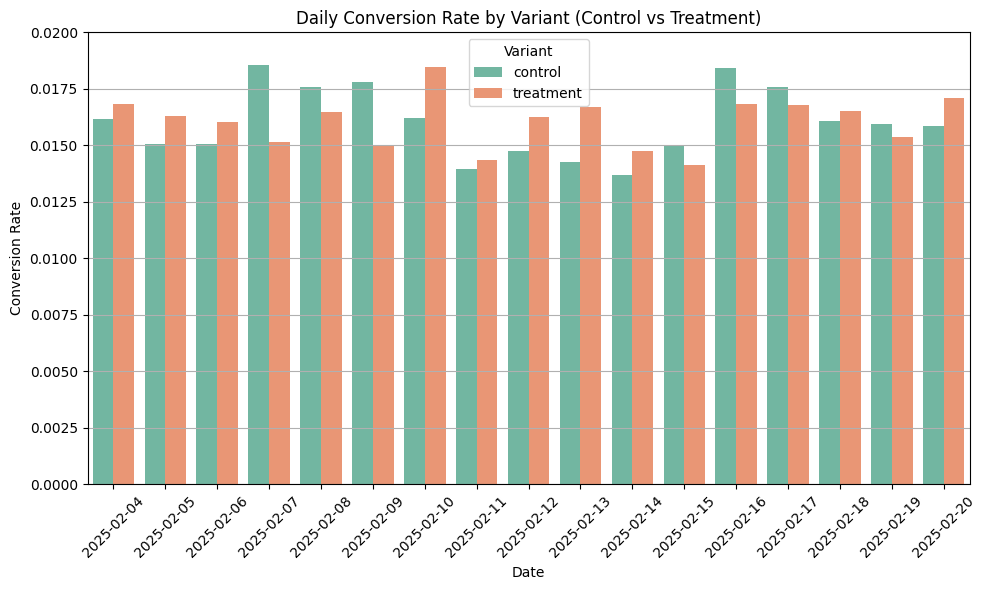

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
user_level_launch_df['attribution_start_date'] = pd.to_datetime(user_level_launch_df['attribution_start_date'])

# Group by date and variant to calculate mean conversion rate
daily_conversion_by_variant = (
    user_level_launch_df
    .groupby(['attribution_start_date', 'variant'])['conversion_indicator']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=daily_conversion_by_variant,
    x='attribution_start_date',
    y='conversion_indicator',
    hue='variant',
    palette='Set2'
)

plt.title('Daily Conversion Rate by Variant (Control vs Treatment)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.ylim(0, 0.02)
plt.grid(axis='y')
plt.legend(title='Variant')
plt.tight_layout()
plt.show()

In [105]:
#Analyze the behavior by spam vs non-spam because the spam detection algo may not have worked correctly

spam_variable_analysis = user_level_launch_df.groupby(['spammer_participant']).agg(
                                                           sum_events = pd.NamedAgg(column='event_counts', aggfunc='mean'),
                                                           launch_rate = pd.NamedAgg(column='launch_indicator', aggfunc='mean'),
                                                           sum_launches = pd.NamedAgg(column='number_of_launches', aggfunc='mean')).reset_index()

spam_variable_analysis = pd.DataFrame(spam_variable_analysis)

spam_variable_AB_analysis = user_level_launch_df.groupby(['spammer_participant','variant']).agg(
                                                           sum_events = pd.NamedAgg(column='event_counts', aggfunc='mean'),
                                                           launch_rate = pd.NamedAgg(column='launch_indicator', aggfunc='mean'),
                                                           sum_launches = pd.NamedAgg(column='number_of_launches', aggfunc='mean')).reset_index()

spam_variable_AB_analysis = pd.DataFrame(spam_variable_AB_analysis)

spam_variable_analysis

#Material differences between participants labelled as Spam vs Non-spam, e.g.: average number of eligble user events, average number of site launches
#Maybe a different algorithm was mistakenly used to classify spam vs non-spam, e.g.: maybe an algorithm used to detect power users vs non-power users was mistakenly

,spammer_participant,sum_events,launch_rate,sum_launches
0,False,1.275080,0.126236,0.173179
1,True,1.127634,0.085288,0.116831


In [106]:
spam_variable_AB_analysis = user_level_launch_df.groupby(['spammer_participant','variant']).agg(
                                                           sum_events = pd.NamedAgg(column='event_counts', aggfunc='mean'),
                                                           launch_rate = pd.NamedAgg(column='launch_indicator', aggfunc='mean'),
                                                           sum_launches = pd.NamedAgg(column='number_of_launches', aggfunc='mean')).reset_index()

spam_variable_AB_analysis = pd.DataFrame(spam_variable_AB_analysis)

spam_variable_AB_analysis

,spammer_participant,variant,sum_events,launch_rate,sum_launches
0,False,control,1.287641,0.138522,0.186906
1,False,treatment,1.264558,0.115945,0.161680
2,True,control,1.094155,0.064921,0.088256
3,True,treatment,1.194284,0.125835,0.173717


In [107]:
import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='launch_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Group A conversion rate: {:.2%}".format(p1))
    print("Group B conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(user_level_launch_df)

Group A conversion rate: 11.84%
Group B conversion rate: 11.73%
P-value (two-tailed): 0.2743
Not statistically significant difference at alpha = 0.05


In [108]:
user_level_launch_df_nospam = user_level_launch_df[user_level_launch_df['spammer_participant'] == False]

user_level_launch_df_nospam

,anon_id,spammer_participant,variant,attribution_start_date,event_counts,number_of_launches,launch_indicator,conversion_indicator
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,1,0,0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,2,1,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,2,0,0,0
6,0001723402b505b1df7a096ae0ca6f50f8349bfb9dbea8...,False,treatment,2025-02-11,1,0,0,0
7,0001b9fc661339f081c496e5d2aaf345c00d1146ba77ea...,False,control,2025-02-04,1,0,0,0
...,...,...,...,...,...,...,...,...
448835,ffff94be0ce4e73fe1e3900713064e2497f0ca261bbfd6...,False,control,2025-02-06,1,1,1,0
448836,ffffb8fee053acf30cb5c95f0e9feab88237b7d35ca4b5...,False,treatment,2025-02-06,1,0,0,0
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,1,0,0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,1,0,0,0


In [109]:
spam_deep_dive = user_level_launch_df.groupby(['anon_id','spammer_participant','variant','attribution_start_date'])['launch_indicator'].sum().reset_index()

user_level_launch_df = pd.DataFrame(user_level_launch_df)

user_level_launch_df

,anon_id,spammer_participant,variant,attribution_start_date,event_counts,number_of_launches,launch_indicator,conversion_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,1,0,0,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,1,0,0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,2,1,0
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,1,0,0,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,2,0,0,0
...,...,...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,1,0,0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,1,0,0,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,1,0,0,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,1,0,0,0


My hypothesis is that the 'spam' classifier was actually picking up power users(high activity accounts) and mislabelling them as spam. If so:
1) The dramatic lift in the 'spam'segment reflects that these users behave very differently(higher baseline engagement and spend)
2) The underperformance in the "non-spam" segment suggeststhat the Test variants actually worsensthe experience for typical users.

In [110]:
#Check significance in the dataset excluding spam

import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='launch_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Control conversion rate: {:.2%}".format(p1))
    print("Treatment conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(user_level_launch_df_nospam)

Control conversion rate: 13.85%
Treatment conversion rate: 11.59%
P-value (two-tailed): 0.0000
Statistically significant difference at alpha = 0.05


In [111]:
user_level_launch_df_spam = user_level_launch_df[user_level_launch_df['spammer_participant'] == True]

user_level_launch_df_spam

,anon_id,spammer_participant,variant,attribution_start_date,event_counts,number_of_launches,launch_indicator,conversion_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,1,0,0,0
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,1,0,0,0
5,00011c5ba878260b0f6e7f2be254a10375a750daf0baf6...,True,treatment,2025-02-12,1,0,0,0
11,00026608540d1bdc7131dafe2c7b9e0620011e80061f6a...,True,treatment,2025-02-07,1,0,0,0
15,0003159dc4ff7eaed3f044e2e56124c334707488078314...,True,control,2025-02-17,1,0,0,0
...,...,...,...,...,...,...,...,...
448819,fffd247d73ba438e026d57b3f1d37ebcc2be029151e1da...,True,control,2025-02-14,1,0,0,0
448824,fffdc9c5377a28a579c2cf83934330c71afe9c1dc5386c...,True,control,2025-02-13,1,1,1,0
448834,ffff90afddc828cfa42a3aa0b9dd6cef7732e93ff6adc4...,True,control,2025-02-16,2,0,0,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,1,0,0,0


In [86]:
#Check significance in the dataset excluding spam

import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='launch_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Control conversion rate: {:.2%}".format(p1))
    print("Treatment conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(user_level_launch_df_spam)

Control conversion rate: 6.49%
Treatment conversion rate: 12.58%
P-value (two-tailed): 0.0000
Statistically significant difference at alpha = 0.05


In [112]:
# Conversion to paid analysis
purchasing_users_df

,anon_id,plan_type,wp_sales_7d
0,bfdebbcfad37f8fa9961719322e66e72b9ad8adfaa44b8...,personal,50.35
1,8d94b0f74717f17732bccde54816d04afa5998954b2f5a...,personal,45.30
2,c9ff4b052a0346afccfab6c923cb1c1af564e82eb1f2d2...,premium,63.45
3,a24404d09975c67a7f91856d39cbfc63eb8ef4b333d2e2...,personal,9.00
4,e37a363a736d4a4e5ae32b19afd46e7df8f3f21d436b87...,personal,48.00
...,...,...,...
14640,05a7e355ec5a24053cce488042ec424c3319545b11a28c...,personal,4.87
14641,04b6ab69cf085a4f21341d0e065a88f2aed48b5c605735...,personal,9.29
14642,a2d471c7de7bff339d13ae5a26c593cf7e310aa3f3bd15...,personal,39.77
14643,50f0325b65b060d1ea2d893eefce11ad2844a71edea6df...,other,13.00


In [113]:
purchase_users = purchasing_users_df.groupby(['anon_id'])['wp_sales_7d'].sum()

purchase_users = pd.DataFrame(purchase_users)

purchase_users

,wp_sales_7d
anon_id,
000548024506b5f1e7b7c01d1a97c4fed7fd6881cb8b05b1bb99a50417c251d3,26.35
0006d37688d5e574bf389bbfd284ec76b871ba5fcdddd2793811021f0877f554,99.36
000b3dad5dba57e38f5ced343f567a9c000ea81d1fb0d85af2a952b4d14d9e02,2.20
001966ba216c8be582c98c3eb02ba58be34b9fb3ee8ef100293f32831b3340b3,50.38
0019bc48ca0f0e87cf7f06734add69a8167fab66edf3920e5b30730d74f784c0,198.00
...,...
ffeb4ec0ed0710943f6338776f991a206fc18f4c3dfd25e263a0b8ef5def39aa,164.60
ffec352b2630c95eb99700c02aa5be7a10bee4dbefae4e1d2a45231a075f542d,45.34
ffef19090b95ad8a975aac9aa8c4c86f542ee77d5c8b2e5557fbfea51c92cca3,66.88


In [114]:
#Summarize launch table at the user level for conversion rate analyses

master_launch_table_df_temp = master_launch_table_df.groupby(['anon_id','spammer_participant','variant','attribution_start_date'])['launch_indicator'].sum().reset_index()

master_launch_table_df_temp = pd.DataFrame(master_launch_table_df_temp)

master_launch_table_df_temp

,anon_id,spammer_participant,variant,attribution_start_date,launch_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,0
...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,0


In [115]:
master_launch_table_df_temp = master_launch_table_df_temp.rename(columns={'launch_indicator':'number_of_launches'})

master_launch_table_df_temp['launch_indicator'] = master_launch_table_df_temp['number_of_launches'].apply(lambda x: 1 if x >= 1 else 0)

master_launch_table_df_temp

,anon_id,spammer_participant,variant,attribution_start_date,number_of_launches,launch_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,0,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,1
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,0,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,0,0
...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,0,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,0,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,0,0


In [116]:
master_conversion_df = pd.merge(master_launch_table_df_temp, purchase_users, left_on='anon_id', right_on='anon_id', how='left')

In [117]:
master_conversion_df

,anon_id,spammer_participant,variant,attribution_start_date,number_of_launches,launch_indicator,wp_sales_7d
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,0,0,NaN
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,0,0,NaN
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,1,NaN
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,0,0,NaN
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,0,0,NaN
...,...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,0,0,NaN
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,0,0,NaN
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,0,0,NaN
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,0,0,NaN


In [118]:
master_conversion_df['sales_7_days'] = master_conversion_df['wp_sales_7d'].fillna(0)

master_conversion_df['converted_indicator'] = master_conversion_df['sales_7_days'].apply(lambda x: 1 if x > 0 else 0)

master_conversion_df

,anon_id,spammer_participant,variant,attribution_start_date,number_of_launches,launch_indicator,wp_sales_7d,sales_7_days,converted_indicator
0,000006eef83ec70ebd648501cf274b35b2f943fb916c22...,True,treatment,2025-02-15,0,0,NaN,0.0,0
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,0,0,NaN,0.0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,1,NaN,0.0,0
3,0000e371949383a5dea06461ea6b806fba7a2a88a85fea...,True,control,2025-02-06,0,0,NaN,0.0,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,0,0,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,0,0,NaN,0.0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,0,0,NaN,0.0,0
448839,ffffe9ca034b07c7e3746c6f7b2b3caa78f79cec72018f...,False,treatment,2025-02-07,0,0,NaN,0.0,0
448840,ffffedbcc3687ab1eaf36ebdc61d02e54b308035667028...,True,control,2025-02-12,0,0,NaN,0.0,0


In [119]:
print(master_conversion_df['converted_indicator'].mean())

0.015981124761051773


In [66]:
print(master_conversion_df.groupby(['variant'])['converted_indicator'].mean())

variant
control      0.015875
treatment    0.016087
Name: converted_indicator, dtype: float64


In [67]:
print(master_conversion_df.groupby(['spammer_participant','variant'])['converted_indicator'].mean())

spammer_participant  variant  
False                control      0.020163
                     treatment    0.017035
True                 control      0.004514
                     treatment    0.010121
Name: converted_indicator, dtype: float64


<ipython-input-121-fd272529abfc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


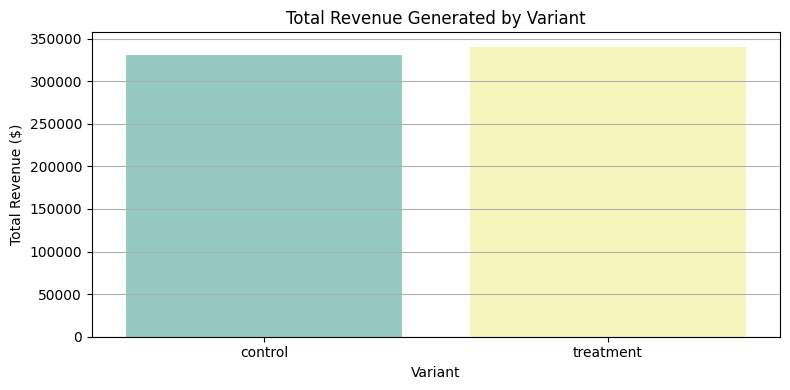

In [121]:
# Group by variant and sum the revenue
revenue_by_variant = (
    master_conversion_df
    .groupby('variant')['sales_7_days']
    .sum()
    .reset_index()
)

# Plot the revenue
plt.figure(figsize=(8, 4))
sns.barplot(
    data=revenue_by_variant,
    x='variant',
    y='sales_7_days',
    palette='Set3'
)

plt.title('Total Revenue Generated by Variant')
plt.xlabel('Variant')
plt.ylabel('Total Revenue ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [68]:
conversion_rate_power_test_df = master_conversion_df.groupby(['variant'])['anon_id'].count()

conversion_rate_power_test_df = pd.DataFrame(conversion_rate_power_test_df)

conversion_rate_power_test_df = conversion_rate_power_test_df.rename(columns={'anon_id': 'event_count'})

conversion_rate_power_test_df

,event_count
variant,
control,223941
treatment,224901


In [69]:
conversion_test_sample_size = min(conversion_rate_power_test_df['event_count'])

conversion_test_sample_size

223941

In [70]:
def ab_test_power(baseline_conversion_rate, minimum_detectable_effect, alpha, beta):
    # Calculate the critical z-scores
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Two-tailed test
    z_beta = stats.norm.ppf(1 - beta)

    # Calculate the effect size
    effect_size = minimum_detectable_effect / math.sqrt(baseline_conversion_rate * (1 - baseline_conversion_rate))

    # Calculate the sample size
    sample_size = (z_alpha + z_beta) ** 2 * (baseline_conversion_rate * (1 - baseline_conversion_rate) + (baseline_conversion_rate + minimum_detectable_effect) * (1 - baseline_conversion_rate - minimum_detectable_effect)) / minimum_detectable_effect**2

    # Return the sample size, rounded up to the nearest integer
    return math.ceil(sample_size)

baseline_conversion_rate = 0.015875  # 1.59% baseline conversion rate
minimum_detectable_effect = 0.005 # 1% minimum detectable effect
alpha = 0.05  # 5% significance level
beta = 0.2  # 20% type II error rate (80% power)

sample_size_per_group = ab_test_power(baseline_conversion_rate, minimum_detectable_effect, alpha, beta)
print(f"Required sample size per group: {sample_size_per_group}")

Required sample size per group: 11322


In [71]:
def check_power(effect_size, sample_size, alpha=0.05, target_power=0.8):
  """
  Checks the statistical power of an A/B test.

  Args:
    effect_size: The minimum detectable effect size.
    sample_size: The sample size per group.
    alpha: Significance level (default 0.05).
    target_power: The desired power level (default 0.8).

  Returns:
    True if the test is underpowered, False otherwise.
  """
  power = smp.tt_ind_solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)
  return power < target_power

# Example usage:
effect_size = 0.01  # Minimum detectable effect size
sample_size = conversion_test_sample_size # Sample size per group
is_underpowered = check_power(effect_size, sample_size)

if is_underpowered:
  print("The A/B test is underpowered.")
else:
  print("The A/B test is adequately powered.")

The A/B test is adequately powered.


 For Conversion Rate (baseline ~1.59 %, assumed MDE 1%), we required ~11K events per arm (variant); we had ~220K exposure events per arm indicating that the test was sufficiently powered

In [79]:
import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='converted_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Group A conversion rate: {:.2%}".format(p1))
    print("Group B conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("NOT statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(master_conversion_df)

Group A conversion rate: 1.59%
Group B conversion rate: 1.61%
P-value (two-tailed): 0.5705
NOT statistically significant difference at alpha = 0.05


In [73]:
conversion_df_nospam = master_conversion_df[master_conversion_df['spammer_participant'] == False]
conversion_df_spam = master_conversion_df[master_conversion_df['spammer_participant'] == True]

conversion_df_nospam

,anon_id,spammer_participant,variant,attribution_start_date,number_of_launches,launch_indicator,wp_sales_7d,sales_7_days,converted_indicator
1,000039124c813d388adb8e8ae492655579cf0a64a2652d...,False,control,2025-02-15,0,0,NaN,0.0,0
2,000044ea351d149aa93281771916b5fe9d91d833110fcc...,False,treatment,2025-02-20,2,1,NaN,0.0,0
4,0000f9fe410b682037b01e581cba69b8b2c17a3355ec00...,False,control,2025-02-19,0,0,NaN,0.0,0
6,0001723402b505b1df7a096ae0ca6f50f8349bfb9dbea8...,False,treatment,2025-02-11,0,0,NaN,0.0,0
7,0001b9fc661339f081c496e5d2aaf345c00d1146ba77ea...,False,control,2025-02-04,0,0,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...
448835,ffff94be0ce4e73fe1e3900713064e2497f0ca261bbfd6...,False,control,2025-02-06,1,1,NaN,0.0,0
448836,ffffb8fee053acf30cb5c95f0e9feab88237b7d35ca4b5...,False,treatment,2025-02-06,0,0,NaN,0.0,0
448837,ffffc49d434dd5fa1dcf61b579ef87b384a2f0f534ee13...,False,treatment,2025-02-07,0,0,NaN,0.0,0
448838,ffffcfa8e5232cee6a96e4e07a35e0341ea9eb0abef328...,False,treatment,2025-02-18,0,0,NaN,0.0,0


In [80]:
import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='converted_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Group A conversion rate: {:.2%}".format(p1))
    print("Group B conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(conversion_df_nospam)

Group A conversion rate: 2.02%
Group B conversion rate: 1.70%
P-value (two-tailed): 0.0000
Statistically significant difference at alpha = 0.05


In [81]:
import pandas as pd
from scipy.stats import norm

def ab_test_significance(df, group_col='variant', outcome_col='converted_indicator', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control']
    group_b = df[df[group_col] == 'treatment']

    # Conversion rates
    p1 = group_a[outcome_col].mean()
    p2 = group_b[outcome_col].mean()

    # Sample sizes
    n1 = len(group_a)
    n2 = len(group_b)

    # Pooled probability
    p_pool = (group_a[outcome_col].sum() + group_b[outcome_col].sum()) / (n1 + n2)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n1 + 1/n2))**0.5

    # Z-score
    z = (p2 - p1) / se

    # P-value
    p_val = 1 - norm.cdf(abs(z))  # one-sided
    p_val_two_tailed = p_val * 2  # two-sided

    # Output results
    print("Group A conversion rate: {:.2%}".format(p1))
    print("Group B conversion rate: {:.2%}".format(p2))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

# Run the test
ab_test_significance(conversion_df_spam)

Group A conversion rate: 0.45%
Group B conversion rate: 1.01%
P-value (two-tailed): 0.0000
Statistically significant difference at alpha = 0.05


In [76]:
#Revenue analyses

print(master_conversion_df.groupby(['variant'])['sales_7_days'].mean())

variant
control      1.475618
treatment    1.513042
Name: sales_7_days, dtype: float64


In [82]:
from scipy.stats import ttest_ind

def ab_test_significance_continuous(df, group_col='variant', outcome_col='sales_7_days', alpha=0.05):
    # Split groups
    group_a = df[df[group_col] == 'control'][outcome_col]
    group_b = df[df[group_col] == 'treatment'][outcome_col]

    # Compute means
    mean_a = group_a.mean()
    mean_b = group_b.mean()

    # Perform independent t-test
    t_stat, p_val_two_tailed = ttest_ind(group_a, group_b, equal_var=False)  # Welch’s t-test

    # Output results
    print("Group A mean: {:.2f}".format(mean_a))
    print("Group B mean: {:.2f}".format(mean_b))
    print("P-value (two-tailed): {:.4f}".format(p_val_two_tailed))

    if p_val_two_tailed < alpha:
        print("Statistically significant difference at alpha = {}".format(alpha))
    else:
        print("Not statistically significant difference at alpha = {}".format(alpha))

ab_test_significance_continuous(master_conversion_df)

Group A mean: 1.48
Group B mean: 1.51
P-value (two-tailed): 0.5012
Not statistically significant difference at alpha = 0.05


In [78]:
# Have used LLM to generate the below piece of code

import pandas as pd
from scipy.stats import chisquare

def check_srm(df, group_col, expected_ratio):
    """
    Checks for sample ratio mismatch (SRM) in an A/B test using a Chi-squared test.

    Args:
        df (pd.DataFrame): DataFrame containing the A/B test data.
        group_col (str): Name of the column indicating the group assignment (e.g., 'A' or 'B').
        expected_ratio (dict): Dictionary specifying the expected ratio for each group.
                               For example: {'A': 0.5, 'B': 0.5} for a 50/50 split.

    Returns:
        tuple: (chi-squared statistic, p-value).
               If the p-value is below a significance level (e.g., 0.05), it suggests an SRM.
    """
    observed_counts = df[group_col].value_counts().to_dict()
    total_samples = len(df)
    expected_counts = {group: ratio * total_samples for group, ratio in expected_ratio.items()}

    observed = list(observed_counts.values())
    expected = list(expected_counts.values())

    if len(observed) != len(expected):
        raise ValueError("Number of observed groups must match number of expected groups")

    chi2_stat, p_value = chisquare(observed, f_exp=expected)
    return chi2_stat, p_value

# Example usage:
expected_ratio = {'A': 0.5, 'B': 0.5}

chi2, p = check_srm(master_conversion_df, 'variant', expected_ratio)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("Sample Ratio Mismatch detected.")
else:
    print("No significant Sample Ratio Mismatch detected.")

Chi-squared statistic: 2.053283783603139
P-value: 0.15187830175023492
No significant Sample Ratio Mismatch detected.
